In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")

In [23]:
def backtest_vix_strategy(asset, commision=None, slippage=None, start_date='2000-01-01', vix_thresholds=None):
    data = pd.DataFrame(yf.download([asset, '^Vix'], start=start_date)['Close'])
    data.columns = [asset, 'VIX']

    data[f'{asset}_Returns'] = data[asset].pct_change().shift(-1)
    data.dropna(inplace=True)

    results = {}
    cumulative_returns_data = []

    for vix_threshold in vix_thresholds:
        temp_data = data.copy()

        temp_data['Signal'] = (temp_data['VIX'] >= vix_threshold).astype(int)
        temp_data['Strategy_Returns'] = temp_data['Signal'] * temp_data[f'{asset}_Returns']

        if commision > 0 or slippage > 0:
            temp_data['trades'] = temp_data['Signal'].diff().abs()
            temp_data['Strategy_Returns'] -= temp_data['trades'] 
            print(temp_data['trades'])
        print(temp_data)

        temp_data['Strategy_Cumulative_Returns'] = (1 + temp_data['Strategy_Returns']).cumprod()
        final_return = temp_data['Strategy_Cumulative_Returns'].iloc[-1]
        results[vix_threshold] = final_return
        cumulative_returns_data.append(temp_data)

    best_threshold = max(results, key=results.get)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,12))

    ax1.plot(data.index, data[asset], label=f'{asset} (SPY)', color='blue')
    ax1.set_ylabel(f'{asset} Price')
    ax1.set_title(f'{asset} - Best VIX Threshold: {best_threshold}')
    ax1.grid(True)
    ax1.legend(loc='upper left')

    ax1_twin = ax1.twinx()
    for temp_data, vix_threshold in zip(cumulative_returns_data, vix_thresholds):
        ax1_twin.plot(temp_data.index, temp_data['Strategy_Cumulative_Returns'], label=f'VIX >= {vix_threshold}')
    ax1_twin.set_ylabel('Cumulative Returns')
    ax1_twin.legend(loc='upper right')

    ax2.plot(data.index, data['VIX'], label='VIX', color='red', alpha=0.6)
    for temp_data, vix_threshold in zip(cumulative_returns_data, vix_thresholds):
        color = ax1_twin.lines[vix_thresholds.index(vix_threshold)].get_color()
        ax2.axhline(vix_threshold, color=color, linestyle='--', alpha=1, lw=2, label=f'VIX Threshold ´{vix_threshold}')

    ax2.set_title(f'VIX Levels')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('VIX Level')
    ax2.legend()
    ax2.grid(True)

    fig.tight_layout()
    plt.show()

    return results

[*********************100%***********************]  2 of 2 completed
C:\Users\juana\AppData\Local\Temp\ipykernel_7316\1459794415.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[f'{asset}_Returns'] = data[asset].pct_change().shift(-1)


                                 AAPL        VIX  AAPL_Returns  Signal  \
Date                                                                     
2000-01-03 00:00:00+00:00    0.999442  24.209999     -0.084310       0   
2000-01-04 00:00:00+00:00    0.915179  27.010000      0.014633       0   
2000-01-05 00:00:00+00:00    0.928571  26.410000     -0.086538       0   
2000-01-06 00:00:00+00:00    0.848214  25.730000      0.047369       0   
2000-01-07 00:00:00+00:00    0.888393  21.719999     -0.017588       0   
...                               ...        ...           ...     ...   
2024-09-26 00:00:00+00:00  227.520004  15.370000      0.001187       0   
2024-09-27 00:00:00+00:00  227.789993  16.959999      0.022872       0   
2024-09-30 00:00:00+00:00  233.000000  16.730000     -0.029142       0   
2024-10-01 00:00:00+00:00  226.210007  19.260000      0.002520       0   
2024-10-02 00:00:00+00:00  226.779999  18.900000      0.000000       0   

                           Strategy_R

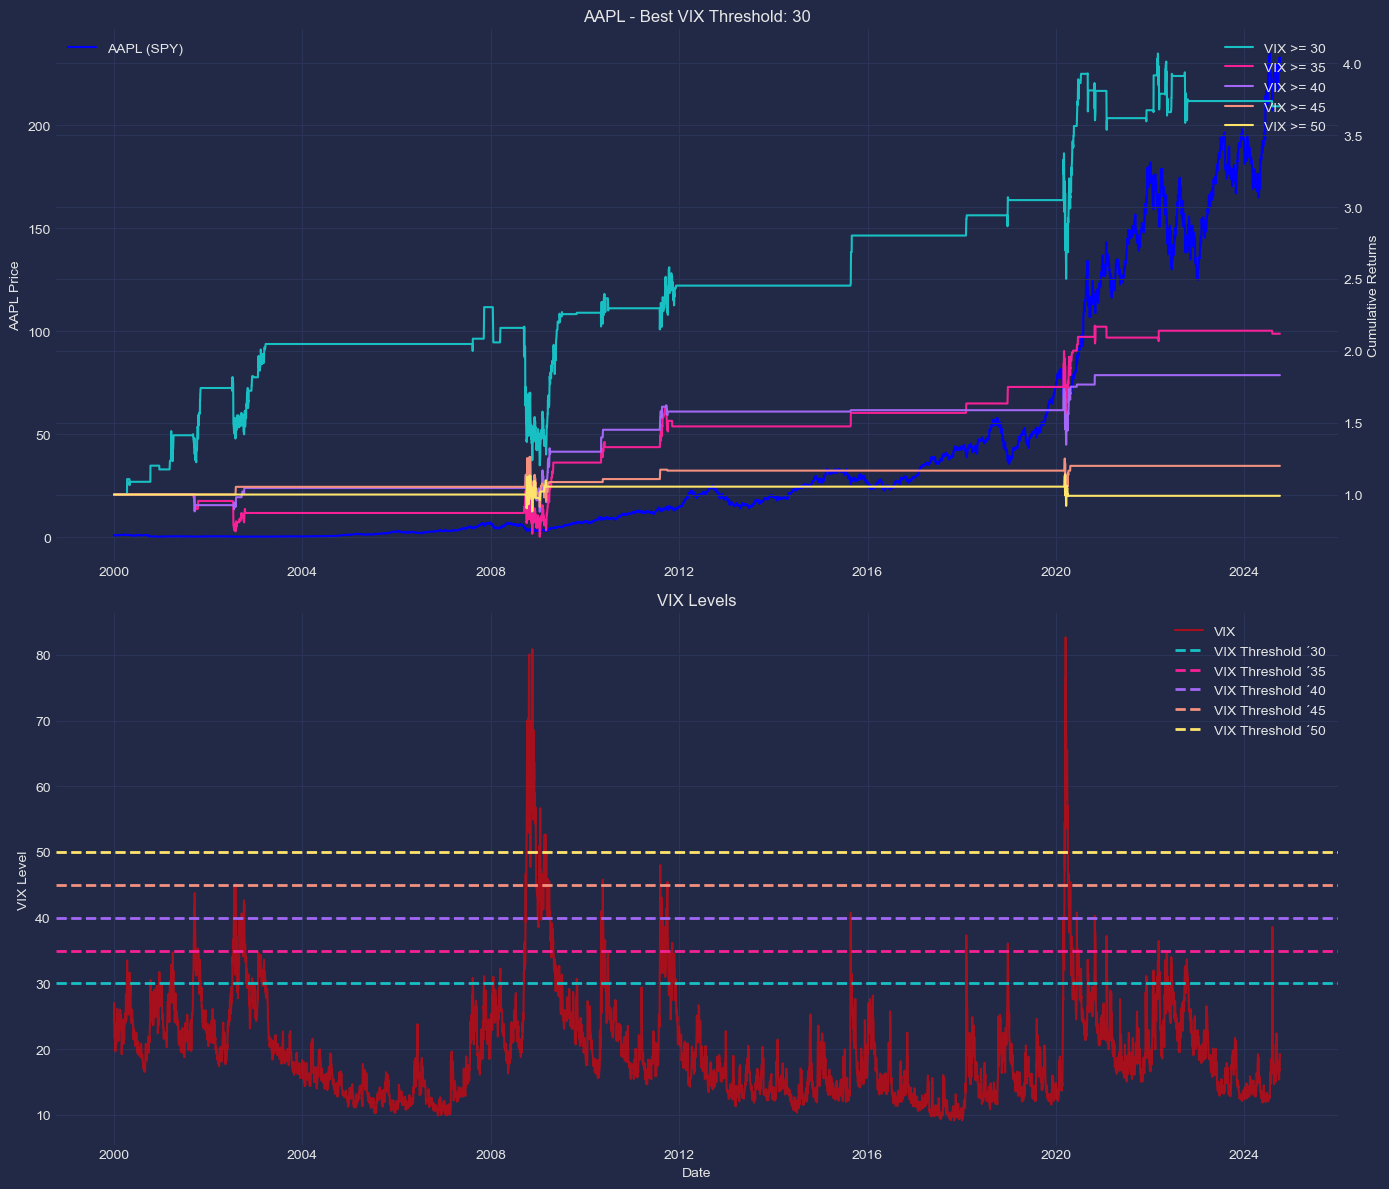

In [28]:
results = backtest_vix_strategy(asset='AAPL', commision=0, slippage=0, start_date='2000-01-01',vix_thresholds=range(30,51,5))